In [1]:
%%capture
import tensorflow as tf
import pprint
import matplotlib.pyplot as plt
import numpy as np
import efficientnet.efficientnet_builder as efnet_builder
import efficientnet.efficientnet_model as efnet_model
# import util

# tf.logging.set_verbosity(tf.logging.WARN)
tf.logging.set_verbosity(tf.logging.ERROR)
# Set locale for printing (e.g. where to place integer separator ','s).
import locale
locale.setlocale(locale.LC_ALL, '')  # Use '' for auto, or force e.g. to 'en_US.UTF-8'

In [2]:
def create_efficientnetb0():
    image_inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    block_args, global_params = efnet_builder.get_model_params('efficientnet-b0', None)
    with tf.variable_scope('efficientnet-b0'):
        model = efnet_model.Model(block_args, global_params)
    features, endpoints = efnet_builder.build_model_base(
        image_inputs, model_name='efficientnet-b0', training=True)
    return model, features

# Layer Dependency Investigation


Zero-ing channels
We want to zero channels that meet one or both of the following criteria:
  - the channels have low overall weight contribution to subsequent layer.
  - the channels don't have any large contribution to any particular layer.

## Layer 0 and (-1)

In [3]:
def skip():
    df = tf.get_default_graph()
    # print('\n'.join((op.name for op in df.get_operations() if 'global' in op.name or 'dense' in op.name)))
    dense_0 = df.get_tensor_by_name('efficientnet-b0/head/dense/kernel:0')
    pool_1 = df.get_tensor_by_name('efficientnet-b0/model/head/global_average_pooling2d/Mean:0')

def skip(): 
    model, _ = create_efficientnetb0()
    model.load_weights(b0_checkpoint_path)

    # 1000 classes
    classes = model._fc
    # 1280 1x1 features
    global_av_pool = model._avg_pooling

In [4]:
b0_meta_path = './resources/efficientnet-b0/model.ckpt.meta'
# b0_checkpoint_path = './resources/efficientnet-b0/checkpoint' 
b0_checkpoint_path = './resources/efficientnet-b0/model.ckpt.index' 

tf.reset_default_graph()
imported_meta = tf.train.import_meta_graph(b0_meta_path)

In [5]:
dense_val = None
with tf.Session() as sess:
    imported_meta.restore(sess, tf.train.latest_checkpoint(
        './resources/efficientnet-b0/'))
    tv = tf.trainable_variables('efficientnet-b0/head/dense')
    dense_0 = tv[0]
    assert 'bias' not in dense_0.name
    dense_val = sess.run(dense_0)
    #tv = tf.trainable_variables('')

In [6]:
flat_dense_val = np.ndarray.flatten(dense_val)

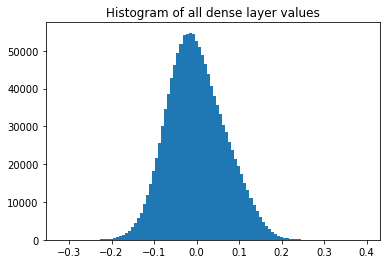

In [7]:
plt.hist(flat_dense_val, bins=100);
plt.title('Histogram of all dense layer values')
plt.show()

In [8]:
print(f'Shape: {dense_val.shape}')
num_features = dense_val.shape[0]
num_classes = dense_val.shape[1]
assert num_classes == 1000
feature_x = np.arange(num_features)
class_x = np.arange(num_classes)

Shape: (1280, 1000)


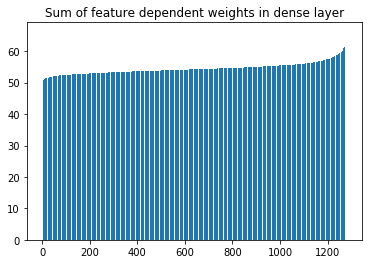

In [9]:
dense_col_sum = np.sort(np.absolute(dense_val).sum(axis=1))
plt.bar(feature_x, dense_col_sum)
plt.title('Sum of feature dependent weights in dense layer')
plt.show()

(1280,)


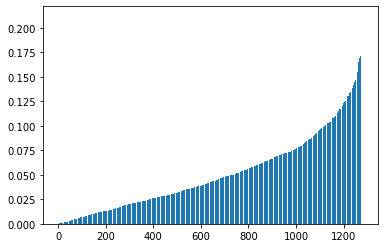

In [10]:
king_penguin_col = dense_val[:, 145]
print(king_penguin_col.shape)
plt.bar(feature_x, np.sort(np.abs(king_penguin_col)));
plt.show()

In [11]:
def min_fraction_of_weights(weight_array, sum_fraction):
    assert len(weight_array.shape) == 1
    assert sum_fraction <= 1.0
    total = weight_array.sum()
    target = total * sum_fraction
    sorted_weights = np.sort(weight_array)
    reverse_sorted = sorted_weights[::-1] # This is just a view into data.
    tally = 0.0
    i = 0
    while tally <= target:
        tally += reverse_sorted[i]
        i += 1
    return i / weight_array.shape[0]

In [12]:
# Example:
print("Penguin col density: {}".format(min_fraction_of_weights(np.abs(king_penguin_col), 0.9)))

Penguin col density: 0.65234375


<BarContainer object of 1000 artists>

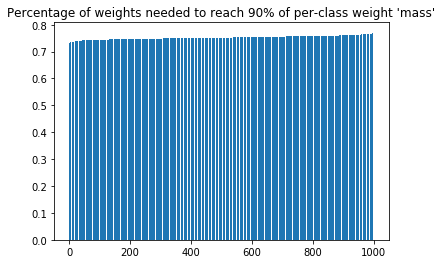

In [14]:
densities = np.apply_along_axis(min_fraction_of_weights, 0, np.abs(dense_val), 0.95)
plt.title('Percentage of weights needed to reach 90% of per-class weight \'mass\'')
plt.bar(class_x, np.sort(densities))

From the above plot we see that, a large proportion (20-30%) of weights
contribute minimally to the overall weight sum. It doesn't follow by necessity
that these low valued weights have little impact. But it is worth investigating.

### Dependency graph and decimation
What number of next-layer channels would need to be ignored in order to disable 
channel in the current layer? For example, how many classes would need to be 
ignored to justify not computing a feature?

#### Assumption 1
An channel contributes to subsequent channel if the connecting weight 
contributes to 95% weight mass assuming descending-order. (Oh, this really needs
some clarification).

#### Update 1
If relu is used, activations are not negative (maybe they are if considering
bias?). Thus negative weights don't contribute to the positive classification of
the current channel.

In [15]:
def argsort_test():
    # i: 0  1  2  3  4  5
    # a: 5, 0, 1, 3, 2, 4
    a = [1, 2, 4, 3, 5, 0]
    expected_arg_sort = [5, 0, 1, 3, 2, 4]
    arg_sorted = np.argsort(a)
    assert np.array_equal(arg_sorted, expected_arg_sort)
argsort_test()

In [3]:
def forward_dependencies(weight_col, threshold_frac=0.95):
    weight_col = np.abs(weight_col)
    assert threshold_frac <= 1.0
    assert len(weight_col.shape) == 1
    total = np.sum(weight_col)
    target = total * threshold_frac
    ordered_weights = np.sort(weight_col)
    rev_ordered_weights = ordered_weights[::-1]
    moved_indices = np.argsort(weight_col)
    moved_indices_rev = moved_indices[::-1]
    tally = 0.0
    i = 0
    while tally < target:
        tally += rev_ordered_weights[i]
        i+=1
    ans = np.zeros(weight_col.shape, dtype=int)
    for i in range(i):
        ans[moved_indices_rev[i]] = 1
    return ans

    return ans


def test_forward_dependencies():
    a = np.array([
            [2, 5],
            [1, 500],
            [5, 50],
            [3, 95],
            [4, 100],
            [0, 250]
     # Sum: 15  1000
    ])
    threshold_frac = 0.80
    expected =  np.array([
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 0],
            [1, 1],
            [0, 1]
     # Sum: 15  1000
    ])
    ans = np.apply_along_axis(forward_dependencies, 0, a, threshold_frac)
    assert np.array_equal(expected, ans)
test_forward_dependencies()

NameError: name 'np' is not defined

<BarContainer object of 1280 artists>

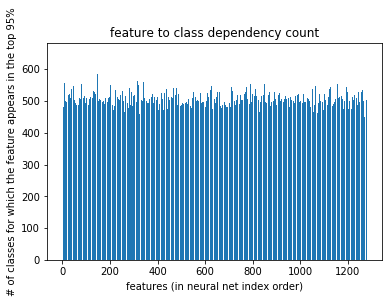

In [17]:
dependencies = np.apply_along_axis(forward_dependencies, 0, dense_val, 0.80)
assert dependencies.shape == (1280, 1000)
sum_dep = np.sum(dependencies, 1)
assert sum_dep.shape == (1280, )
plt.title('feature to class dependency count')
plt.ylabel('# of classes for which the feature appears in the top 95%')
plt.xlabel('features (in neural net index order)')
plt.bar(feature_x, sum_dep)

<BarContainer object of 1280 artists>

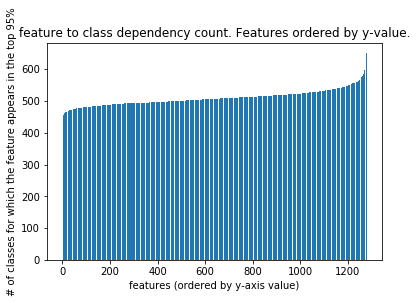

In [18]:
plt.title('feature to class dependency count. Features ordered by y-value.')
plt.ylabel('# of classes for which the feature appears in the top 95%')
plt.xlabel('features (ordered by y-axis value)')
plt.bar(feature_x, np.sort(sum_dep))

### It looks like class-feature-layer dependencies are dense!
Oh wow! There is no opportunity to ignore any feature channels! We would have
to ignore almost half of all classes to begin to ignore any feature channel at
all!

### The curve above looks very much like one I've seen in relation to information entropy.
Could this be a way to detect channels that have more room for compression?

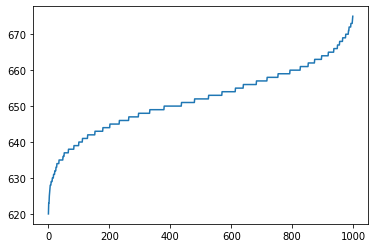

In [19]:
num_dependencies = np.sum(dependencies, 0)
plt.plot(class_x, np.sort(num_dependencies))

## Actual dependencies contributions
The true dependencies between layers must account for the activation 
distribution of the dataset. For example, despite having a large weight 
connecting a class and feature, it might be the case that the given feature is
rarely, if ever, highly activated.

In addition, we only want to consider the weights when the class is the correct
class. Edit: no, that's incorrect. The weights might be important for insuring 
that a class is _not_ the predicted (incorrectly) class. Although, would this
only be the case for negative weights? Yes, positive weights are constructive 
for the correct class only, and negative weights are constructive for all but
the correct class. There would be:

    1.2 x 10^6 images * 1280 features / image * 4 bytes per weight ~= 10 GB

10 GB of weight data, which we can't easily manipulate. So maybe let's leave 
this perspective on the data for the moment. Edit: wait, we can summarize 
the relationship while collecting the data- only sum an activation if it is 
constructively contributing to the correct class. This gets a bit more 
complicated if this is taken into account. What if an excitation is 
'constructive' in the sense that the positivity of the activation results in 
an increase in the correct class sigmoid activation, but it contributes _more_
to a different class. Given that everything is relative, that's actually 
overall a negative contribution to the correct result. If we store a 1280x1000
matrix of contributions, we can account for that later, as we have all the data.

### count(activation * weight in top 95% mass)
Needs to be streamed, as we can't store 10GB of activations.

In [62]:
%%capture
import tensorflow as tf
import pprint
import matplotlib.pyplot as plt
import numpy as np
import efficientnet.efficientnet_builder as efnet_builder
import efficientnet.efficientnet_model as efnet_model
import micronet.dataset.imagenet as imagenet_ds
import efficientnet.utils as efutils
tf.logging.set_verbosity(tf.logging.ERROR)

In [63]:
def constructive_contributions(global_pool_out, dense_weights, y):
    assert type(y) == int
    # Promote the 1d pool output to 2d. When using element-wise multiply
    # via np.multiply, the 1280x1 vector will be broadcast to all 1000
    # columns of dense_weights.
    global_pool_out_2d = np.squeeze(global_pool_out)[:, np.newaxis]
    contributions = np.multiply(dense_weights, global_pool_out_2d)
    contribution_sign = -1 * np.ones(dense_weights.shape)
    contribution_sign[:,y] = 1 # Only the correct class has positive sign.
    # This is the intermediate result.
    contributions = np.multiply(contributions, contribution_sign)
    # Final result
    contributions_sum = np.sum(contributions, axis=1)
    contributions = np.zeros(contributions.shape)
    contributions[:, y] = contributions_sum
    return contributions
    
def test_constructive_contributions():
    #                    0  1  2          
    pool_out = np.array([1, 0.5, -2])
    #                 C1 C2 C3
    dense_weights = np.array(
        [[1, 0, 2],
         [0, 1, 0],
         [-2,3, 0]])
    correct_class = 1
    contrib = constructive_contributions(pool_out, dense_weights, correct_class)
    # The 1st feature has negative contributions (-1, -2) via positive
    # co-efficients linked to C1 & C3 (both incorrect classes). The 2nd feature
    # has 0.5 positive contribution for boosting the correct class neuron. The
    # 3rd feature has -4 and -6 contributions for again boosting the incorrect
    # classes C1 and C3
    expected_contrib_intermediate = np.array(
        [[-1, 0, -2],
         [0, 0.5, 0],
         [-4, -6, 0]])
    # The final result maps contributions to the output neuron which we are
    # considering- considering to remove.
    expected_contrib = np.array(
        [[0, -3, 0],
         [0, 0.5, 0],
         [0, -10, 0]])
    assert np.array_equal(contrib, expected_contrib)
test_constructive_contributions()

In [64]:
image_size = 224
# Reset
tf.reset_default_graph()
eval_input_fn = imagenet_ds.create_eval_input(image_size, 
                                              num_parallel_calls=1,                
                                              for_tpu=False).input_fn
params = {'batch_size': 1}
dataset = eval_input_fn(params)
iterator = dataset.make_one_shot_iterator()
image_input, y = iterator.get_next()
# Create model.
logits, endpoints = efnet_builder.build_model(image_input, 
                                              model_name='efficientnet-b0', 
                                              training=False)
global_pool = endpoints['global_pool']
# prediction = tf.argmax(logits, axis=1)
b0_meta_path = './resources/efficientnet-b0/model.ckpt.meta'
# b0_checkpoint_path = './resources/efficientnet-b0/checkpoint' 
b0_checkpoint_path = './resources/efficientnet-b0/model.ckpt.index'
b0_checkpoint_dir = './resources/efficientnet-b0/'
# imported_meta = tf.train.import_meta_graph(b0_meta_path)

In [65]:
eval_ckpt_driver = efutils.EvalCkptDriver('efficientnet-b0')

In [66]:
per_feature_counts = np.zeros(1280)
per_class_counts = np.zeros(1000)
num_samples = 3000 # 1*10**3
dependencies_sum = np.zeros([1280, 1000])
with tf.Session() as sess:
    # imported_meta.restore(sess, tf.train.latest_checkpoint(
    #   './resources/efficientnet-b0/'))
    eval_ckpt_driver.restore_model(sess, b0_checkpoint_dir)
    tv = tf.trainable_variables('efficientnet-b0/head/dense')
    dense_0 = tv[0]
    assert 'bias' not in dense_0.name
    # image_input_val, y_val = sess.run([image_input, y])
    for i in range(num_samples):
        global_pool_out, dense_weights, y_val = sess.run([global_pool, 
                                                          dense_0, 
                                                          y])
        y_val = int(np.squeeze(y_val))
        # Promote the 1d pool output to 2d. When using element-wise multiply
        # via np.multiply, the 1280x1 vector will be broadcast to all 1000
        # columns of dense_weights.
        # Simple contributions
        # global_pool_out_2d = np.squeeze(global_pool_out)[:, np.newaxis]
        # contributions = np.multiply(dense_weights, global_pool_out_2d)
        # Smart contributions
        contributions = constructive_contributions(global_pool_out, 
                                                   dense_weights, y_val)
        # Ignore negatives.
        contributions = contributions.clip(min=0)
        assert contributions.shape == dense_weights.shape == (1280, 1000)
        dependencies = np.apply_along_axis(forward_dependencies, 0, contributions, threshold_frac=0.90)
        dependencies_sum += dependencies
        #per_feature_counts += dependencies.sum(1)
        #per_class_counts += dependencies.sum(0)

### The meaning of dependencies_sum

    val = dependencies_sum[feature_id][class_id]
    
here val is the total number of times that feature_id contributed to classifying
class_id.

In [92]:
saved_dependences = np.copy(dependencies_sum) # This took ages to calculate, so making a backup.

[[0. 0. 0. ... 1. 3. 0.]
 [1. 5. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 3.]
 [0. 1. 0. ... 1. 4. 2.]]


Text(0.5, 1.0, 'the (total) count of output classes that depend on a feature')

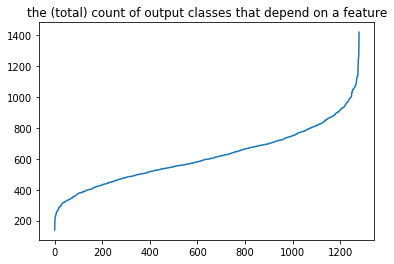

In [83]:
plt.plot(np.sort(dependencies_sum.sum(1)))
plt.title('the (total) count of output classes that depend on a feature')

Text(0.5, 1.0, 'the chance that a feature will constructively contribute to the ans')

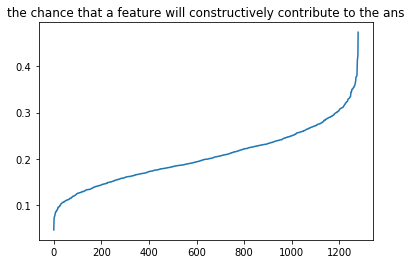

In [99]:
plt.plot(np.sort(dependencies_sum.sum(1))/(num_samples))
plt.title('the chance that a feature will constructively contribute to the ans')

The above plot shows that:
* for half of the features, there is less that 25% chance that they are needed 
  on any given example.
  

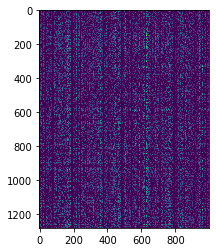

In [85]:
plt.imshow(dependencies_sum)

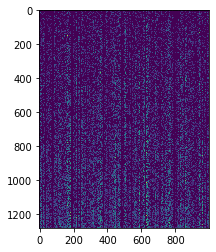

In [86]:
row_sum = np.sum(dependencies_sum, axis=1)
idx = np.argsort(row_sum)
sorted_dependencies = dependencies_sum[idx, :]
plt.imshow(sorted_dependencies)

### If we were to half the number of features, how many classes would we need to rule out?

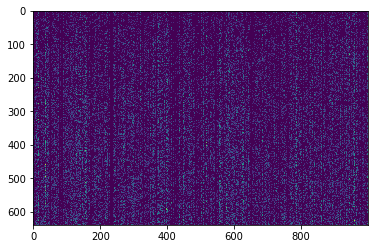

In [87]:
sorted_dependencies_top = sorted_dependencies[0:640, :]
plt.imshow(sorted_dependencies_top)

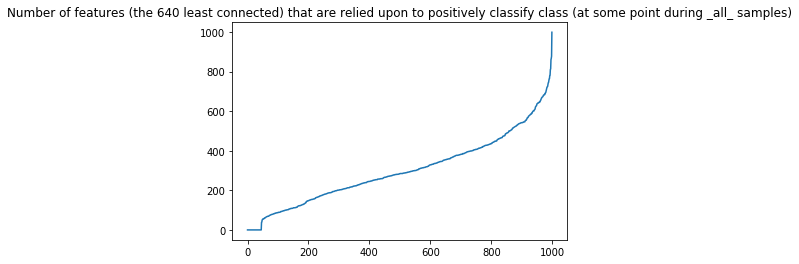

In [94]:
class_requirements = np.sum(sorted_dependencies_top, axis=0)
plt.title('Number of features (the 640 least connected) that are relied upon to '
          'positively classify class (at some point during _all_ samples)')
plt.plot(np.sort(class_requirements))
plt.show()

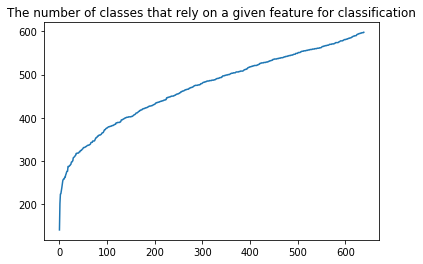

In [97]:
plt.title('The number of classes that rely on a given feature for '
          'classification')
plt.plot(np.sort(np.sum(sorted_dependencies_top, axis=1)))

This above chart shows the number of classes that would be needed to be ruled
out before we start to 

### Every zero in the dependency matrix represents a weight that can be zero-ed. 
How many are there?

In [89]:
non_zeros = np.count_nonzero(dependencies_sum)
zeros = (1280 * 1000) - non_zeros
fraction_of_zeros = zeros / (1280 * 1000)
print(f'zeros: {zeros}, non-zeros: {non_zeros}, fraction: {fraction_of_zeros}')

zeros: 789276, non-zeros: 490724, fraction: 0.616621875


There are 57129 (4.5%) weights that do not contribute to at least 90% of the 
final activation value _in any example_. The hypothesis is that these elements
can be dropped with low chance of making a prediction transition from correct
to incorrect.

In [90]:
at_1_percent = np.size(np.where(np.reshape(dependencies_sum,-1) <= num_samples * 0.01))
fraction = at_1_percent / (1280 * 1000)
print(f'affecting only 1%: {at_1_percent}, fraction: {fraction}')

affecting only 1%: 1280000, fraction: 1.0


There are 111,218 (8.7%) of weights that contribute to 1% or less. See the above
comment for details on how we try to estimate 'contribute', and what it means.

In [91]:
a = 20/(20+52000)
b = 80/(80+65000)
print(f'a:{a}, b:{b}')

a:0.00038446751249519417, b:0.001229256299938537


### For the given sample, 